In [ ]:
import dlib
import numpy as np
import path
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageColor
from psd_tools import PSDImage
import Obstruct
%matplotlib inline

In [ ]:
DIR = './LFWcrop/faces'
IMAGE_LIST = path.glob.glob(DIR + '/*') 

In [ ]:
model = dlib.face_recognition_model_v1("models/dlib_face_recognition_resnet_model_v1.dat")
N = 63200
THRESHOLD = 0.6

### Случайные серые прямоугольники

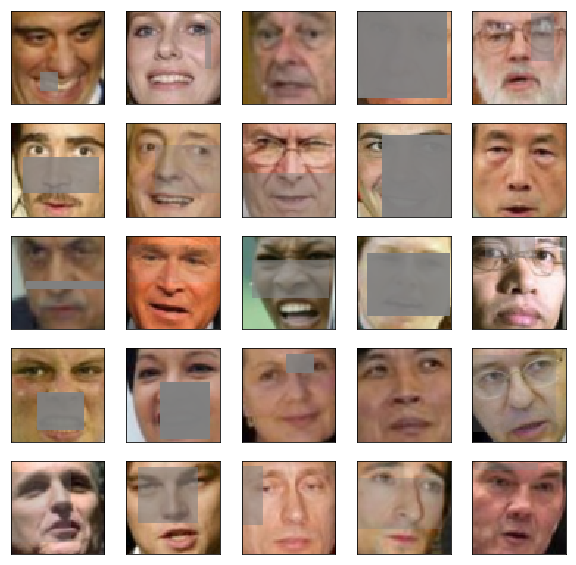

In [ ]:
imges = [Obstruct.getRandomImageList(IMAGE_LIST) for _ in range(25)]
imges = [Obstruct.obstructShape(img, 'rectangle', pos='random', size='random', color='gray', alpha='random')
         for img in imges]
Obstruct.visualizePlt(imges, gridsize=(5,5))

### Позиционные прямоугольники

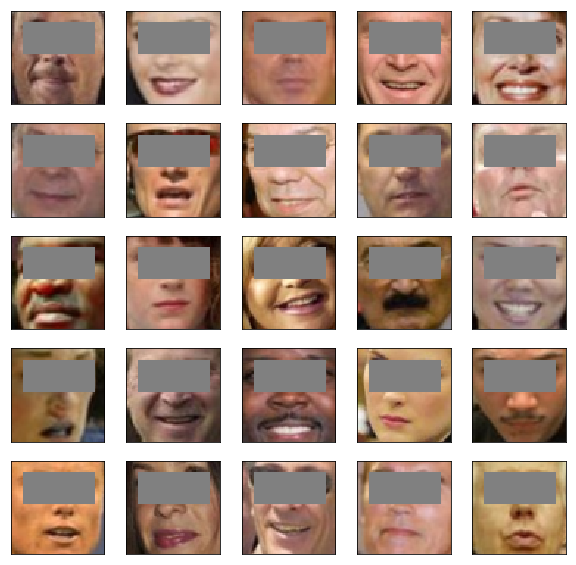

In [ ]:
imges = [Obstruct.getRandomImageList(IMAGE_LIST) for _ in range(25)]
imges = [Obstruct.obstructEyesSimple(img) for img in imges]
Obstruct.visualizePlt(imges, gridsize=(5,5))

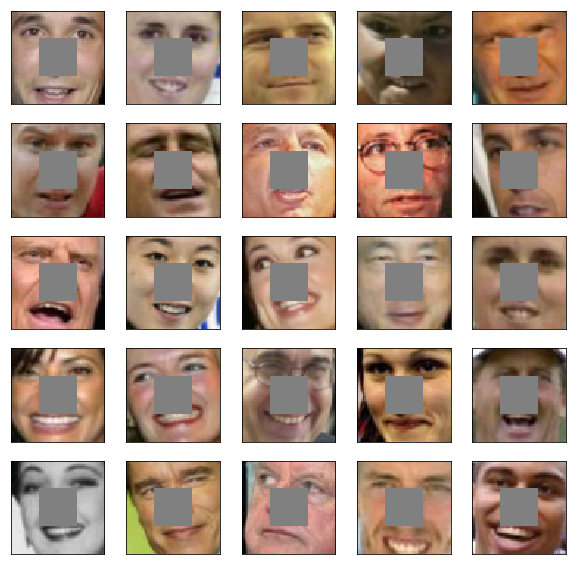

In [ ]:
imges = [Obstruct.getRandomImageList(IMAGE_LIST) for _ in range(25)]
imges = [Obstruct.obstructNoseSimple(img) for img in imges]
Obstruct.visualizePlt(imges, gridsize=(5,5))

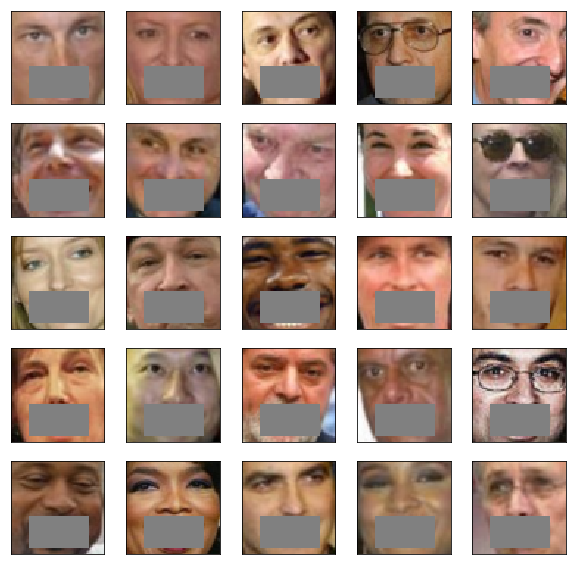

In [ ]:
imges = [Obstruct.getRandomImageList(IMAGE_LIST) for _ in range(25)]
imges = [Obstruct.obstructMouthSimple(img) for img in imges]
Obstruct.visualizePlt(imges, gridsize=(5,5))

### Реалистичные шаблоны

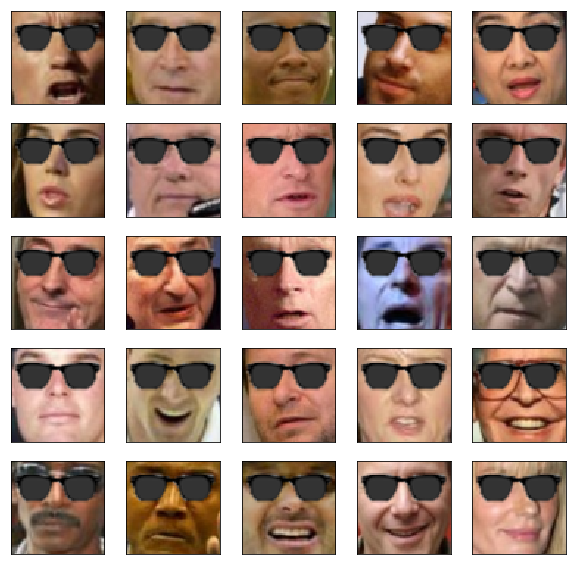

In [ ]:
imges = [Obstruct.getRandomImageList(IMAGE_LIST) for _ in range(25)]
imges = [Obstruct.obstructEyesSunglasses(img) for img in imges]
Obstruct.visualizePlt(imges, gridsize=(5,5))

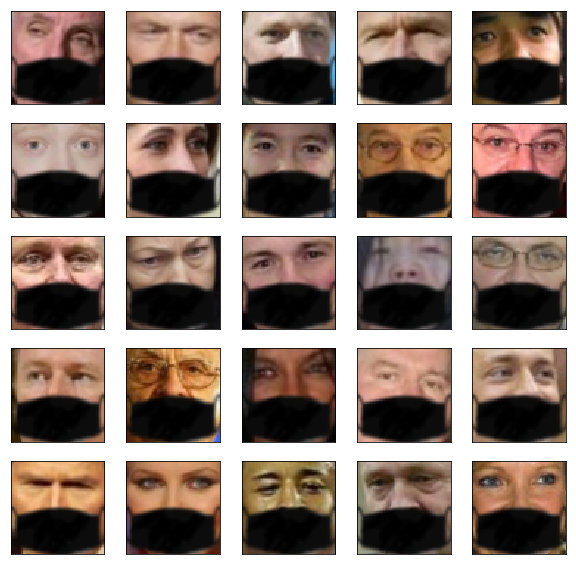

In [ ]:
imges = [Obstruct.getRandomImageList(IMAGE_LIST) for _ in range(25)]
imges = [Obstruct.obstructMouthBlackMask(img) for img in imges]
Obstruct.visualizePlt(imges, gridsize=(5,5))

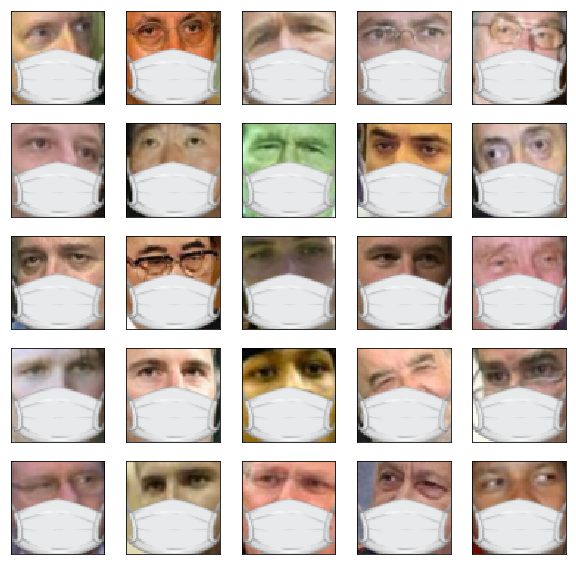

In [ ]:
imges = [Obstruct.getRandomImageList(IMAGE_LIST) for _ in range(25)]
imges = [Obstruct.obstructMouthWhiteMask(img) for img in imges]
Obstruct.visualizePlt(imges, gridsize=(5,5))

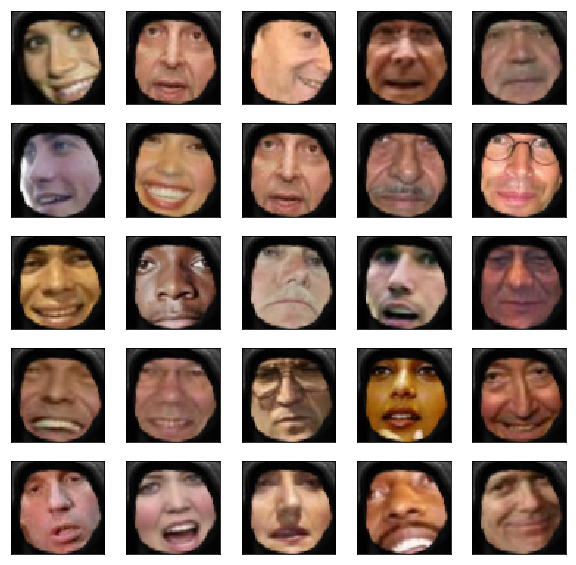

In [ ]:
imges = [Obstruct.getRandomImageList(IMAGE_LIST) for _ in range(25)]
imges = [Obstruct.obstructHeadHood(img) for img in imges]
Obstruct.visualizePlt(imges, gridsize=(5,5))

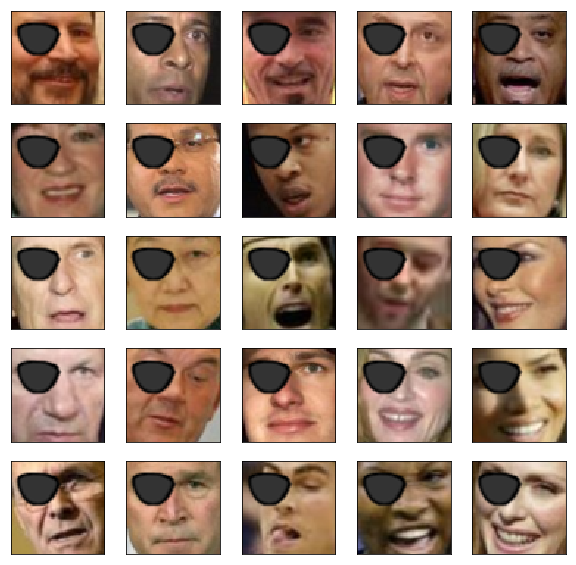

In [ ]:
imges = [Obstruct.getRandomImageList(IMAGE_LIST) for _ in range(25)]
imges = [Obstruct.obstructEyesEyepatch(img) for img in imges]
Obstruct.visualizePlt(imges, gridsize=(5,5))

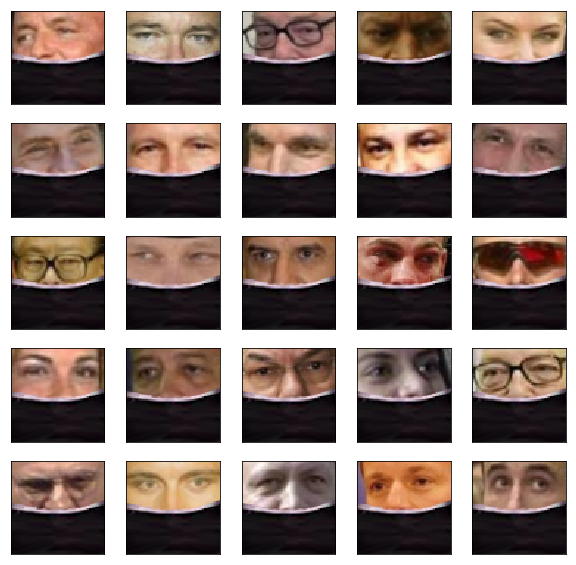

In [ ]:
imges = [Obstruct.getRandomImageList(IMAGE_LIST) for _ in range(25)]
imges = [Obstruct.obstructMouthScarf(img) for img in imges]
Obstruct.visualizePlt(imges, gridsize=(5,5))

### Демонстрация падения качества модели Face Recognition

In [ ]:
def LFWcropGenerator(augmentation=None, shape=(150, 150), verbose=False):
    lists = path.glob.glob('./LFWcrop/lists/*')
    for list_ in lists:
        gt = 1 if list_.split('/')[-1].split('.')[0][-4:] == 'same' else 0
        if verbose:
            print(f"Opening {list_}...")
        with open(list_, 'r') as inf:
            for line in inf:
                imges = [Image.open("./LFWcrop/faces/{}.ppm".format(img)) for img in line.strip().split()]
                if augmentation is not None:
                    imges = [augmentation(img).convert("RGB") for img in imges]
                yield np.stack([np.array(img.resize(shape)) for img in imges], axis=0), gt

In [ ]:
clear_gen = LFWcropGenerator()
sunglasses_gen = LFWcropGenerator(augmentation=lambda img: Obstruct.obstructEyesSunglasses(img))
mask_gen = LFWcropGenerator(augmentation=lambda img: Obstruct.obstructMouthWhiteMask(img))

In [ ]:
%%time
for (gen, name) in zip([clear_gen, sunglasses_gen, mask_gen],
                       ["Clear images", "Sunglasses", "White mask"]):
    correct = 0
    for pair, gt in gen:
        descs = np.array(model.compute_face_descriptor(pair))
        pred = np.linalg.norm(descs[0] - descs[1])
        correct += gt == (pred <= THRESHOLD)
    print(f"{name}: {correct / N} accuracy")

Clear images: 0.9257594936708861 accuracy
Sunglasses: 0.8169462025316455 accuracy
White mask: 0.7290664556962025 accuracy
CPU times: user 21min 38s, sys: 3min 59s, total: 25min 37s
Wall time: 25min 37s


In [ ]:
clear_gen = LFWcropGenerator()
eyes_gen = LFWcropGenerator(augmentation=lambda img: Obstruct.obstructEyesSimple(img))
nose_gen = LFWcropGenerator(augmentation=lambda img: Obstruct.obstructNoseSimple(img))
mouth_gen = LFWcropGenerator(augmentation=lambda img: Obstruct.obstructMouthSimple(img))

In [ ]:
%%time
for (gen, name) in zip([clear_gen, eyes_gen, nose_gen, mouth_gen],
                       ["Clear images", "Eyes obstruction", "Nose obstruction", "Mouth obstruction"]):
    correct = 0
    for pair, gt in gen:
        descs = np.array(model.compute_face_descriptor(pair))
        pred = np.linalg.norm(descs[0] - descs[1])
        correct += gt == (pred <= THRESHOLD)
    print(f"{name}: {correct / N} accuracy")

Clear images: 0.9257594936708861 accuracy
Eyes obstruction: 0.7179905063291139 accuracy
Nose obstruction: 0.808006329113924 accuracy
Mouth obstruction: 0.883117088607595 accuracy
CPU times: user 29min 58s, sys: 5min 29s, total: 35min 27s
Wall time: 35min 26s


In [ ]:
%%time
alphas = np.linspace(0, 1, 11).astype(float)
accs = []
for alpha in alphas:
    gen = LFWcropGenerator(augmentation=lambda img: Obstruct.obstructShape(img, 'rectangle', pos='random',
                                                                           size='random', color='gray', alpha=alpha))
    correct = 0
    for pair, gt in gen:
        descs = np.array(model.compute_face_descriptor(pair))
        pred = np.linalg.norm(descs[0] - descs[1])
        correct += gt == (pred <= THRESHOLD)
    acc = correct / N
    print(f"alpha={alpha}: {acc} accuracy")
    accs.append(acc)

alpha=0.0: 0.9257594936708861 accuracy
alpha=0.1: 0.9250474683544304 accuracy
alpha=0.2: 0.9213291139240506 accuracy
alpha=0.30000000000000004: 0.9159018987341773 accuracy
alpha=0.4: 0.9078006329113925 accuracy
alpha=0.5: 0.8990822784810126 accuracy
alpha=0.6000000000000001: 0.8841772151898735 accuracy
alpha=0.7000000000000001: 0.8637974683544304 accuracy
alpha=0.8: 0.8245411392405063 accuracy
alpha=0.9: 0.7633069620253164 accuracy
alpha=1.0: 0.7230537974683544 accuracy
CPU times: user 1h 20min 58s, sys: 14min 39s, total: 1h 35min 37s
Wall time: 1h 35min 36s


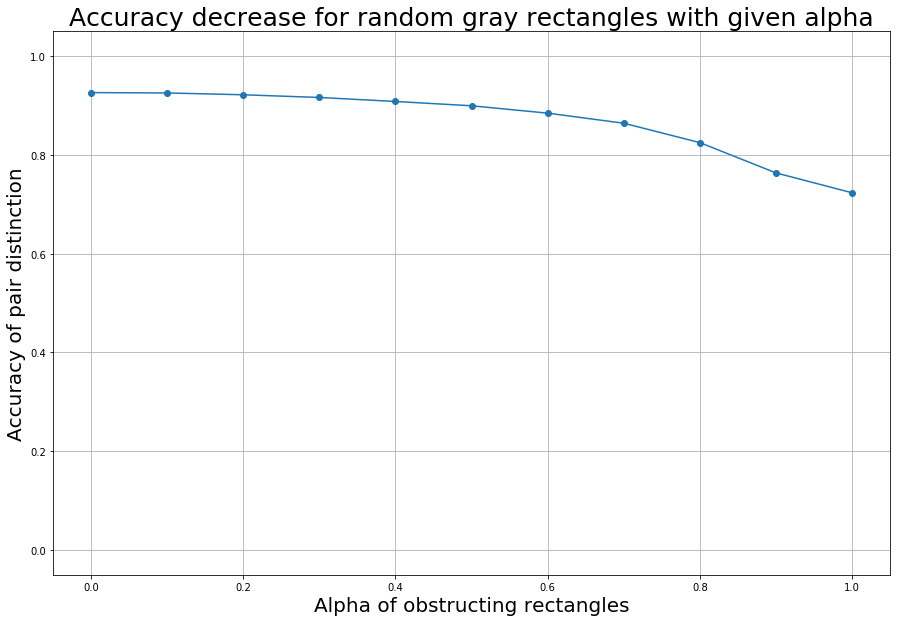

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(alphas, accs, '-o')
plt.ylim(-0.05, 1.05)
plt.xlabel('Alpha of obstructing rectangles', fontsize=20)
plt.ylabel('Accuracy of pair distinction', fontsize=20)
plt.title('Accuracy decrease for random gray rectangles with given alpha', fontsize=25)
plt.grid()
plt.show()

In [ ]:
%%time
sizes = np.linspace(0.1, 0.9, 5).astype(float)
accs = [0.9257594936708861]
for size in sizes:
    gen = LFWcropGenerator(augmentation=lambda img: Obstruct.obstructShape(img, 'rectangle', pos='random',
                                                                           size=(float(size), float(size)), 
                                                                           color='gray', 
                                                                           alpha=Obstruct.MAX_COLOR))
    correct = 0
    for pair, gt in gen:
        descs = np.array(model.compute_face_descriptor(pair))
        pred = np.linalg.norm(descs[0] - descs[1])
        correct += gt == (pred <= THRESHOLD)
    acc = correct / N
    print(f"size={size}: {acc} accuracy")
    accs.append(acc)

size=0.1: 0.9207911392405064 accuracy
size=0.30000000000000004: 0.8638291139240506 accuracy
size=0.5: 0.7764398734177215 accuracy
size=0.7000000000000001: 0.5640981012658228 accuracy
size=0.9: 0.5 accuracy
CPU times: user 36min 37s, sys: 6min 39s, total: 43min 17s
Wall time: 43min 16s


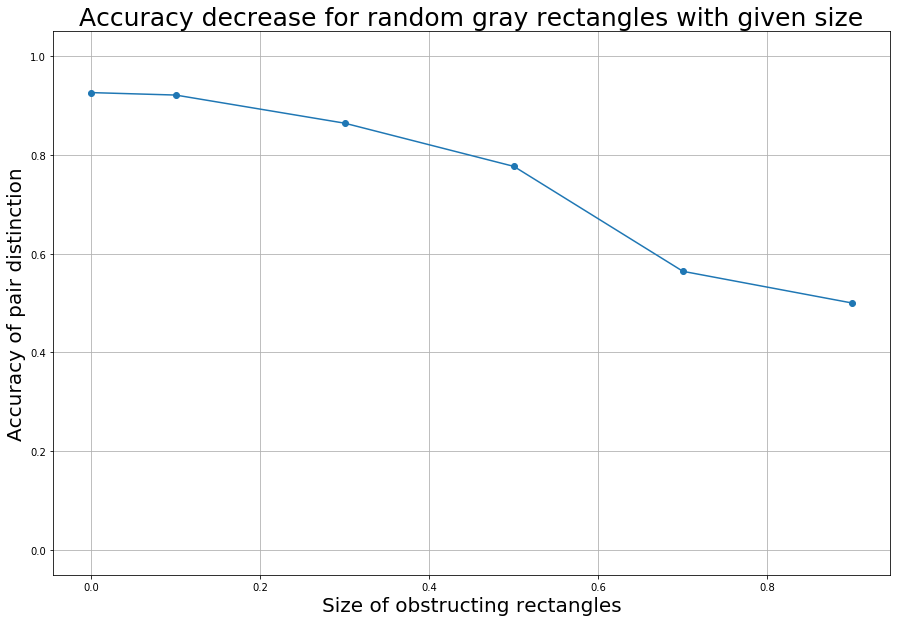

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot([0] + list(sizes), accs, '-o')
plt.ylim(-0.05, 1.05)
plt.xlabel('Size of obstructing rectangles', fontsize=20)
plt.ylabel('Accuracy of pair distinction', fontsize=20)
plt.title('Accuracy decrease for random gray rectangles with given size', fontsize=25)
plt.grid()
plt.show()